In [1]:
#imports
import sys
import subprocess 
import importlib

import time

import numpy as np

import scipy.constants as con
import scipy.optimize as opt
import scipy.linalg as la
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
from scipy.interpolate import interp1d 

from numba import njit

#Nice plots
import matplotlib.pyplot as plt
import matplotlib.ticker as plticks
from mpl_toolkits.axes_grid1 import inset_locator
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 5.1
fontsize = 10
plt.rcParams.update({
    'text.usetex'        : True,
    'font.family'        : 'sans-serif',
    'font.size'          : fontsize,
    'text.latex.preamble': r'\usepackage{libertine}'
})
#plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
import re
from pylatexenc.latexencode import UnicodeToLatexEncoder, \
 UnicodeToLatexConversionRule, RULE_REGEX
u2latex = UnicodeToLatexEncoder(
    conversion_rules=[
        UnicodeToLatexConversionRule(rule_type=RULE_REGEX, rule=[
            (re.compile(r'𝜈'), r'\\ensuremath{\\nu}'),
            (re.compile(r'𝛾'), r'\\ensuremath{\\gamma}'),
            (re.compile(r'⁻'), r'\\ensuremath{^-}'),
            (re.compile(r'⁺'), r'\\ensuremath{^+}'),
        ]),
        'defaults'
    ]
)
#class for adding units to axis
class AddK(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' K'
        return s
    
class AddMeV(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' MeV'
        return s

#Reaction networks
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()
#import H2_AoT_net as bbn_np
import np_AoT_net as bbn_np
import AoT_net as bbn_Li
#import bbn_test_integrate as bbn_Li
import full_AoT_net as bbn_full
#import full_size_net as bbn_full
networks=[bbn_np,bbn_Li,bbn_full]
importlib.reload(bbn_full)
importlib.reload(bbn_Li)
importlib.reload(bbn_np)
#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc if isinstance(net.nnuc, int) else net.nnuc() for net in networks]+[2]

In [2]:
#Unit conversions
timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
molcm3=216117376    #conversion factor for mol/cm^3 (cm^3*MeV^3)/(hbar^3*c^3*Avagadro number)
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV

#constants
n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015


#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

In [3]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3

    

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,40)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,40)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,40)])  

### Initial conditions ###
t_max=1769922*timeunit
T_ini=27/TMeV2T9                     #initial temperature in MeV
t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=m_p*n_b_ini           #initial baryon density

def rho_nu(a): #neutrino energy density
    return rho_nu_ini/a**4#+0.0075/(1+0.8*T**2)*rho_nu_ini/a**4

def rho_b(T,a):
    return 0#rho_b_ini/a**3#+3/2*T*n_b_ini/a**3

#T**3/(T_ini**3*11/4)=1/a**3

def drho_b(T,a):
    return 0#3*rho_b_ini*T**2/(T_ini**3*11/4)

def P_b(T,a):
    return 0#T*n_b_ini/a**3

### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(T,a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(T,a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T)+drho_b(T,a))/(rho_set(T,a) + P_b(T,a)+P_e(T)+P_gamma(T)))

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

t_range=[t_ini,t_max]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature


# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=1e-80,rtol=1e-8,t_eval=np.geomspace(*t_range,2000000))#,t_eval=t_space)

Tsqr=sol.y[0]**-2
asqrt=sol.y[1]**2
solt=sol.t

@njit
def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt,Tsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a_cache(t):
    return np.sqrt(np.interp(t,solt,asqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(1e4*timeunit)**3)*a_cache(1e4*timeunit)**3


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3
    




In [4]:
n_b_ini

5.129599848530015e-09

In [5]:
#Functions for determining additional abundances for each network
Yp=[]
Yp_err=[]
D=[]
D_err=[]
He3=[]
He3_err=[]
Li7=[]
Li7_err=[]
[eta_ini*n_gamma_ini ]#

xvals=np.geomspace(1e-10,1e-9,50)
for eta in xvals:
    eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini)))
    n_b_ini=eta_ini*n_gamma_ini 
    #Initial conditions from thermal equilibrium
    def get_Y_thermal(Y,n,T):
        Y_2 = np.zeros(n)
        Y_2[:len(Y)] = Y
        if T>0.5:#set to zero if out of equilibrium (3 seconds or 0.5MeV)
            for i in range(len(Y),n):
                tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
                Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]
        return Y_2

    def solve_using_svd(U, s, Vh, b):
        bb = U.T @ b
        y = bb/s
        x = Vh.T @ y
        return x

    #Initial conditions from Jacobian
    def get_Y_jac(y,i):

        #if y[0]<0.1
        #    return 
        AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
        AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
        aY_cut=Altersort(get_Y_thermal(y[2:][:nNucs[i-1]],nNucs[i],y[0]))

        Yj = np.array([YY for YY in aY_cut])
        
        
        for cut in range(nNucs[i-1], len(Yj) - 2, 1):
            for j in range(10):
                fyj = -AdYdt_cut(Yj)
                jac = AdYdt_jac_cut(Yj)
                if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                    print('Yj:', Yj)
                    raise ValueError
                if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                    print('Yj:', Yj)
                    print('fyj:', fyj)
                    raise ValueError
                # Implement cut:
                fyj = fyj[cut:]
                jac = jac[cut:, cut:]
                
                # Solution using SVD
                U, s, Vh = la.svd(jac)    
                x = solve_using_svd(U, s, Vh, fyj)
                for k in range(1):
                    #A · δx = A · (x + δx) − b
                    residuals = jac @ x - fyj
                    dx = solve_using_svd(U, s, Vh, residuals)
                    x -= dx
                Yj[cut:] += x
        return list(PNAsort(Yj))

    #times for switching between networks
    t_start=[t_ini,1*timeunit,60*timeunit,t_max]

    #Solve the system
    #initial conditions

    solY=np.array([[1/(np.exp(Q/T_cache(t_start[0]))+1)],[1/(np.exp(-Q/T_cache(t_start[0]))+1)]])
    soltime=np.array([t_start[0]])
    evals=0
    for i in range(len(networks)):
        print(i)
        #ft_space=[point for point in data[:,0] if point>t_cut]

        initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
        #if i==1:
        #    initial_param[0]+=4e-4
        #    initial_param[1]-=4e-4
        #else:
        #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
            return jac

        #full derivative
        def dydt(t,Y): 
            result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA)#,first_step=timeunit*1e-3)#,)

        evals+=jacsolY.nfev
        abun=[abun[-1] for abun in jacsolY.y]
        
        solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))

    #interabuns.append(abun)
    #interEvals.append(evals)
    #solYs.append(solY)
    #soltimes.append(soltime)
    print(eta)
    Yp.append(4*abun[5])
    Yp_err.append(4e-3*abun[5])
    D.append(abun[2]/abun[1])
    D_err.append(abun[2]/abun[1]*2e-2)
    He3.append((abun[3]+abun[4])/abun[1])
    He3_err.append((abun[3]+abun[4])/abun[1]*2e-2)
    Li7.append((abun[7]+abun[9])/abun[1])
    Li7_err.append((abun[7]+abun[9])/abun[1]*0.1)


0
1
2
1e-10
0
1
2
1.0481131341546874e-10
0
1
2
1.0985411419875572e-10
0
1
2
1.1513953993264481e-10
0
1
2
1.2067926406393264e-10
0
1
2
1.2648552168552956e-10
0
1
2
1.3257113655901109e-10
0
1
2
1.389495494373136e-10
0
1
2
1.4563484775012443e-10
0
1
2
1.5264179671752364e-10
0
1
2
1.5998587196060573e-10
0
1
2
1.67683293681101e-10
0
1
2
1.7575106248547894e-10
0
1
2
1.8420699693267163e-10
0
1
2
1.9306977288832535e-10
0
1
2
2.0235896477251554e-10
0
1
2
2.1209508879201924e-10
0
1
2
2.222996482526191e-10
0
1
2
2.329951810515372e-10
0
1
2
2.4420530945486546e-10
0
1
2
2.5595479226995335e-10
0
1
2
2.6826957952797273e-10
0
1
2
2.811768697974225e-10
0
1
2
2.94705170255181e-10
0
1
2
3.088843596477485e-10
0
1
2
3.23745754281764e-10
0
1
2
3.39322177189533e-10
0
1
2
3.5564803062231214e-10
0
1
2
3.7275937203149375e-10
0
1
2
3.9069399370546207e-10
0
1
2
4.094915062380419e-10
0
1
2
4.291934260128778e-10
0
1
2
4.4984326689694537e-10
0
1
2
4.71486636345739e-10
0
1
2
4.941713361323838e-10
0
1
2
5.179474679231

In [6]:
Yp

[0.22208477019616168,
 0.22319036718216143,
 0.2242478922952413,
 0.22526044659821867,
 0.22623099592172144,
 0.22716236226695763,
 0.22805721896887365,
 0.22891808842158742,
 0.22974734211418651,
 0.23054720300668294,
 0.23131974971512215,
 0.2320669209037458,
 0.2327905218616905,
 0.23349223052217677,
 0.23417360495643896,
 0.2348360898166703,
 0.2354810238916112,
 0.2361096468810602,
 0.23672310626161802,
 0.23732246362539325,
 0.23790870109619064,
 0.2384827270588018,
 0.2390453818055279,
 0.23959744241112707,
 0.24013962800959535,
 0.24067260389985978,
 0.24119698587975472,
 0.24171334411912312,
 0.24222220649471585,
 0.24272406225122495,
 0.24321936476715322,
 0.24370853450108335,
 0.24419196141266789,
 0.24467000747027207,
 0.24514300892620547,
 0.2456112779584342,
 0.24607510503455385,
 0.246534760214492,
 0.24699049495101094,
 0.2474425431216184,
 0.24789112305024624,
 0.2483364380670272,
 0.24877867782377125,
 0.24921801972172133,
 0.24965462917122316,
 0.25008866087273574,
 

[0.00367213 0.03672131]


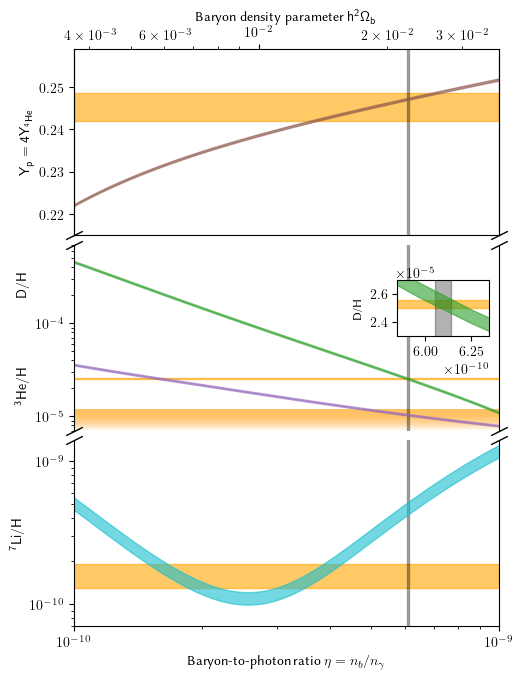

In [7]:


'''
np.random.seed(19680801)

pts = np.random.rand(30)*.2
# Now let's make two outlier points which are far away from everything.
pts[[3, 14]] += .8
pts[[8, 23]] -= 1.2
'''
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
#fig, axes = plt.subplots(1, 1, figsize=(width, 4))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(5, 7))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,figsize=(width, 7))
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.97, bottom=0.105, top=0.93)

#fig.subplots_adjust(hspace=0.05)  # adjust space between axes
#fix x axis
plt.xscale('log')

plt.xlabel('Baryon-to-photon ratio $\eta=n_b/n_\gamma$')

ax1.set_ylabel('$\\mathsf{Y_p=4Y_{{}^4 He}}$')
ax2.set_ylabel('$\\mathsf{{}^3 He/H \hspace*{5em} D/H  }$')
ax3.set_ylabel('$\\mathsf{{}^7 Li/H}$')
#ax1.twiny()
#\/
'''
# plot the same data on both axes
ax1.plot(pts)
ax2.plot(pts)
ax3.plot(pts)
'''
#ax1.plot(xvals,Yp,'0.6')
#ax2.plot(xvals,D,'0.6')
#ax2.plot(xvals,He3,'0.6')
res=len(xvals)

ax1.fill_between(xvals, np.ones(res)*(0.2453-0.0034), np.ones(res)*(0.2453+0.0034), alpha=0.6, color='orange')

obseta=6.1e-10*np.array([1+1.6/224,1-1.6/224])
ax1.fill_between(obseta, [0,0], [1,1], alpha=0.3, color='k')


ax1.fill_between(xvals, np.array(Yp) - np.array(Yp_err), np.array(Yp) + np.array(Yp_err), alpha=0.6, color=colors[5])

ax2.fill_between(xvals, np.ones(res)*(2.527-0.03)*1e-5, np.ones(res)*(2.527+0.03)*1e-5, alpha=0.6, color='orange')
#ax2.fill_between(xvals, np.ones(res)*(1.1-0.2)*1e-5, np.ones(res)*(1.1+0.2)*1e-5, alpha=0.6, color='orange')
yData=np.ones(res)*(1+0.2)*1e-5
for x in np.geomspace(1e-5,7e-6,40):
  ax2.fill_between(xvals, x, yData, where=yData >x, facecolor='orange', alpha=0.02)


ax2.fill_between(obseta, [0,0], [1,1], alpha=0.3, color='k')

ax2.fill_between(xvals, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), alpha=0.6, color=colors[2])

ax2.fill_between(xvals, np.array(He3) - np.array(He3_err), np.array(He3) + np.array(He3_err), alpha=0.6, color=colors[4])



ax3.fill_between(xvals, np.ones(res)*(1.6-0.3)*1e-10, np.ones(res)*(1.6+0.3)*1e-10, alpha=0.6, color='orange')

ax3.fill_between(obseta, [0,0], [1,1], alpha=0.3, color='k')

ax3.fill_between(xvals, np.array(Li7) - np.array(Li7_err), np.array(Li7) + np.array(Li7_err), alpha=0.6, color=colors[9])
'''
x = np.linspace(0, 10, 1000)
y = np.exp(x/5)-2

ax1.plot(x, y)
ax2.plot(x, y)
ax3.plot(x, y)
'''
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.215, .259)  # outliers only
ax2.set_ylim(0.7e-5, 7e-4)
ax2.set_yscale('log')
ax3.set_ylim(0.7e-10, 1.4e-9)
ax3.set_yscale('log')


plt.xlim(xvals[0],xvals[-1])


# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)

#fix for second top axis
ax1.spines.top.set_visible(False)
ax1.tick_params(axis='x', colors='w', which='both')

ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(False)
ax3.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.tick_params(axis='x', colors='w', which='both')
ax3.xaxis.tick_bottom()


sub_axes = plt.axes([.77, .52, .18, .08]) 
#sub_axes.plot(xvals, np.array(D), c = 'k') 

sub_axes.fill_between(xvals, np.ones(res)*(2.527-0.03)*1e-5, np.ones(res)*(2.527+0.03)*1e-5, alpha=0.6, color='orange')

sub_axes.fill_between(obseta, [0,0], [1,1], alpha=0.3, color='k')

sub_axes.fill_between(xvals, np.array(D) - np.array(D_err), np.array(D) + np.array(D_err), alpha=0.6, color=colors[2])

sub_axes.set_xlim(5.85e-10, 6.35e-10)
sub_axes.set_ylim(2.3e-5, 2.7e-5)
sub_axes.set_ylabel('\\small{D/H }')
#sub_axes.set_yscale('log')
#sub_axes.set_xscale('log')
# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),     I used '$\sim$' to replaced [(-1, -d), (1, d)]
# (1,0), and (1,1) are the four corners of the axes.   /4.171*6.1e-10
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping. 

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)


topax=ax1.twiny()
topax.set_xlim(np.array(ax1.get_xlim())/6.1e-10*0.0224)
print(np.array(ax1.get_xlim())/6.1e-10*0.0224)
topax.set_xscale('log')

#topticks=np.array([1e-10,2e-10,5e-10,1e-09])
#topax.set_xticks(topticks)
#topax.set_xticklabels(topticks)

topax.set_xlabel('Baryon density parameter $\\mathsf{ h^2\Omega_b}$')

#fig.savefig('TeX/figures/etaplot.pdf')
#ax1.set_xscale(2)
plt.show()

In [8]:
from mpl_toolkits.axes_grid1 import inset_locator

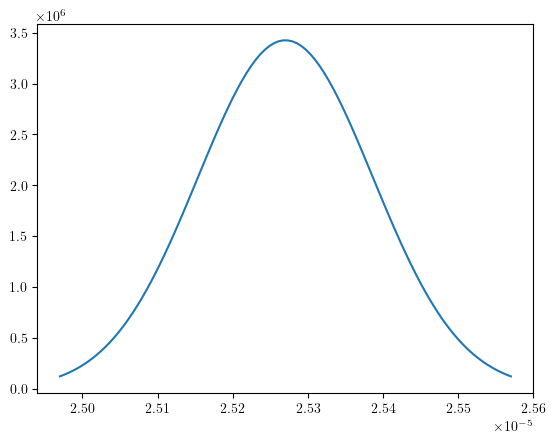

In [9]:
def gauss(x, mu, sig):
    return 1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mu)/sig)**2/2)

import scipy.optimize as opt
sigma=opt.fsolve(lambda sig: integrate.quad(gauss,2.497e-5, 2.557e-5, args=(2.527e-5,sig))[0]-0.99,x0=1e-5)[0]

x=np.linspace(2.497e-5,2.557e-5,100)
plt.plot(x,gauss(x,2.527e-5,sigma))

In [10]:
plt.figure()
plt.plot(etaL,gauss( np.array(Dabun) ,2.527e-5,sigma))
#plt.plot(etaL,gauss( np.array(Dabun) ,2.527e-5,sigma))

NameError: name 'etaL' is not defined

<Figure size 640x480 with 0 Axes>

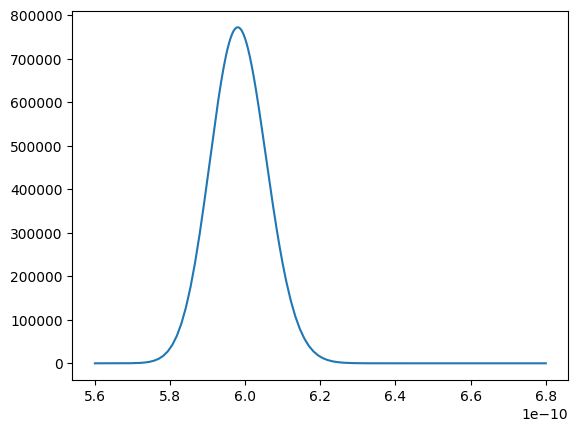

In [ ]:
plt.figure()
plt.plot(etaL,gauss(np.array(Dabun),2.527e-5,sigma+4e-7))

In [ ]:
eee=0
for i in range(200):
    if gauss(np.array(Dabun[eee]),2.527e-5,sigma+4e-7)<gauss(np.array(Dabun[i]),2.527e-5,sigma+4e-7):
        eee=i
etaL[eee]

5.980808080808081e-10

In [ ]:
Dabun

[2.811250619886969e-05,
 2.8014529851912227e-05,
 2.791707363239812e-05,
 2.782012910813865e-05,
 2.7723698136166582e-05,
 2.7627780454105685e-05,
 2.7532363391961037e-05,
 2.7437444506560935e-05,
 2.734302602805144e-05,
 2.724909401696246e-05,
 2.7155655547266275e-05,
 2.7062702056844554e-05,
 2.6970231375152593e-05,
 2.687823699447655e-05,
 2.6786718234260475e-05,
 2.6695670298552975e-05,
 2.6605090715753872e-05,
 2.651497528614872e-05,
 2.642531843563069e-05,
 2.633612227281461e-05,
 2.6247378376745525e-05,
 2.6159087556284964e-05,
 2.607124207793974e-05,
 2.5983840922136448e-05,
 2.5896879786433217e-05,
 2.5831948379773765e-05,
 2.5817549824740706e-05,
 2.5810356085847446e-05,
 2.5803165570425063e-05,
 2.578879382025883e-05,
 2.5774433685212736e-05,
 2.5760086940618517e-05,
 2.5745752290755916e-05,
 2.5731428415874145e-05,
 2.5724270836377867e-05,
 2.5717116528960294e-05,
 2.5702816452565155e-05,
 2.568852854276144e-05,
 2.5674252690113258e-05,
 2.5659988021717043e-05,
 2.564573611